<a href="https://colab.research.google.com/github/machiwao/CCMACLRL_PROJECT_COM222/blob/main/project_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of Shopee Computer Product Reviews

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

!pip install stanza
import stanza

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 19.1 MB/s eta 0:00:00


## Data Loading

In [2]:
df = pd.read_csv("hf://datasets/magixxixx/shopee-product-reviews-on-computer-category/combined-dataset-shuffled-cased-40K.csv")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
df.head()

,text,sentiment
0,mali yung dineliver 2l order ko naging 1l bulok!,0
1,xl order ko dumating large.nkalagay sa sticker...,0
2,"sobrang bilis ma lowbat, hindi masyado nakaka ...",0
3,first time ko umorder dito. di naman gumagana ...,0
4,"not well packed, wala itong box. hindi sya ma ...",0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       40000 non-null  object
 1   sentiment  40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [5]:
df.isnull().sum()

,0
text,0
sentiment,0


In [6]:
df.duplicated().sum()

1

In [7]:
df['sentiment'].value_counts()

,count
sentiment,
0,20000
1,20000


## Data Preprocessing

In [8]:
df.drop_duplicates(inplace = True)

In [9]:
df['text'] = df['text'].str.lower()

In [10]:
df['text'] = df['text'].str.replace('[^a-zA-Z]', ' ')
df['text'] = df['text'].str.replace('http\S+|www.\S+', '', case=False)
df['text'] = df['text'].str.replace(r'\d+', '')
df['text'] = df['text'].str.replace(r'[^\w\s]+', '')
df['text'] = df['text'].str.strip()
df['text'] = df['text'].str.replace(r'\s+', ' ')
df['text'] = df['text'].str.replace(r'^\s+', '')
df['text'] = df['text'].str.replace(r'\s+$', '')

In [11]:
filipino_stopwords = set([
        'akin', 'aking', 'ako', 'alin', 'am', 'amin', 'aming', 'ang', 'ano',
        'anumang', 'apat', 'at', 'atin', 'ating', 'ay', 'ba', 'bababa', 'bago',
        'bakit', 'bawat', 'bilang', 'dahil', 'dalawa', 'dapat', 'din', 'dito',
        'doon', 'eh', 'gagawin', 'gayunman', 'ginagawa', 'ginawa', 'ginawang',
        'gumawa', 'gusto', 'ha', 'habang', 'hanggang', 'hindi', 'huwag', 'hoy',
        'iba', 'ibaba', 'ibabaw', 'ibig', 'ikaw', 'ilagay', 'ilalim', 'ilan',
        'inyong', 'isa', 'isang', 'itaas', 'ito', 'iyo', 'iyon', 'iyang','iyong', 'ka',
        'kahit', 'kailangan', 'kailanman', 'kami', 'kanila', 'kanilang',
        'kanino', 'kanya', 'kanyang', 'kapag', 'kapwa', 'karamihan',
        'katiyakan', 'katulad', 'kaya', 'kaysa', 'ko', 'kong', 'kulang',
        'kumuha', 'kung', 'laban', 'lahat', 'lamang', 'likod', 'lima', 'maaari',
        'maaaring', 'maging', 'mahusay', 'makita', 'marami', 'marapat',
        'masyado', 'may', 'mayroon', 'mga', 'minsan', 'mismo', 'mula', 'muli', 'na',
        'nabanggit', 'naging', 'nagkaroon', 'nais', 'nakita', 'namin', 'nang',
        'napaka', 'narito', 'nasaan', 'ng', 'ngayon', 'ngunit', 'ni', 'nila', 'nilang',
        'nito', 'niya', 'niyang', 'noon', 'o', 'pa', 'paano', 'pababa',
        'paggawa', 'pagitan', 'pagkakaroon', 'pagkatapos', 'pala', 'palabas',
        'pamamagitan', 'panahon', 'pangalawa', 'para', 'paraan', 'pareho',
        'pataas', 'pero', 'po', 'pumunta', 'pumupunta', 'sa', 'saan', 'sabi',
        'sabihin', 'sarili', 'sila', 'sino', 'siya',
        'tatlo', 'tayo', 'tulad', 'tungkol', 'una', 'walang', 'yan', 'yung', 'username'
    ])

english_stopwords = set(stopwords.words('english'))
combined_stopwords = filipino_stopwords.union(english_stopwords)

df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (combined_stopwords)]))

In [12]:
lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
'''porter = PorterStemmer()
df['text'] = df['text'].apply(lambda x: ' '.join([porter.stem(word) for word in x.split()]))'''

"porter = PorterStemmer()\ndf['text'] = df['text'].apply(lambda x: ' '.join([porter.stem(word) for word in x.split()]))"

## Training the Model

In [13]:
X = df['text']
y = df['sentiment']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [15]:
combined_stopwords_list = list(combined_stopwords)
'''vectorizer = CountVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)'''
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.9, min_df=5, stop_words=combined_stopwords_list)
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

In [16]:
from sklearn.svm import SVC

model = SVC()

In [ ]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)
    # Predict on test data
    y_pred = model.predict(X_test)
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    return accuracy, report

# Initialize models
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier()
}

# Train and evaluate each model
for model_name, model in models.items():
    accuracy, report = train_and_evaluate_model(model, X_train_transformed, y_train, X_test_transformed, y_test)
    print(f"{model_name}:\nAccuracy: {accuracy}\nReport:\n{report}\n")

Naive Bayes:
Accuracy: 0.96325
Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      3968
           1       0.98      0.95      0.96      4032

    accuracy                           0.96      8000
   macro avg       0.96      0.96      0.96      8000
weighted avg       0.96      0.96      0.96      8000


Logistic Regression:
Accuracy: 0.964875
Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3968
           1       0.97      0.96      0.96      4032

    accuracy                           0.96      8000
   macro avg       0.96      0.96      0.96      8000
weighted avg       0.97      0.96      0.96      8000


SVM:
Accuracy: 0.97075
Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3968
           1       0.97      0.97      0.97      4032

    accuracy                           0.97      8000
   macro

In [18]:
# Chosen Model
model = SVC()
model.fit(X_train_transformed, y_train)

SVC()

In [19]:
y_pred = model.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3968
           1       0.98      0.96      0.97      4032

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000



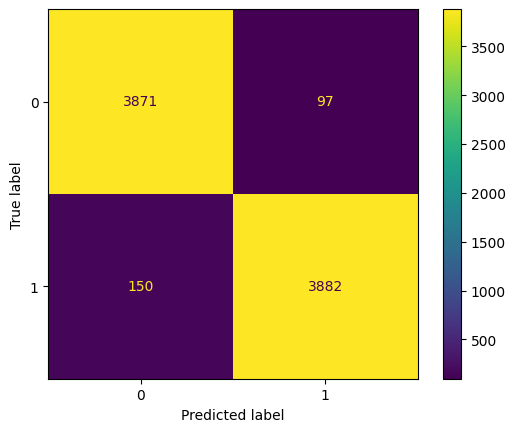

In [20]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [21]:
input_text = pd.Series("Oh my god. Best costumer service. Salamat sa mabilis na delivery. Mag-oorder ulit ako sa inyo")
input_text_transform = vectorizer.transform(input_text)
prediction = model.predict(input_text_transform)
prediction

array([1])

In [42]:
input_text = pd.Series("Mali yung nareceive na product pero okay lang rin. Tangina mo shopee pero Quick delivery tho so thank you")
input_text_transform = vectorizer.transform(input_text)
prediction = model.predict(input_text_transform)
prediction

array([1])

In [45]:
input_text = pd.Series("So I chose this over a lot of products and It's functional. Thank you")
input_text_transform = vectorizer.transform(input_text)
prediction = model.predict(input_text_transform)
prediction

array([0])

In [40]:
input_text = pd.Series("Pinili ko itong product sa mga ibang produkto, swerte at tama ang desisyon ko. Hindi ako bobo mga inutil AAAAA. Salamat seller")
input_text_transform = vectorizer.transform(input_text)
prediction = model.predict(input_text_transform)
prediction

array([0])

In [50]:
input_text = pd.Series("Mgandaaaaaaa sssssyyyyyyyyyyyyaaaaaaaaa kasssssaiIIIIII ffffffffffaaaaaaaaaasssssssssssttttttttt chhhhhhhaaaaaaarrrrrrrrrggggggggggiiiiiNNNNggggg")
input_text_transform = vectorizer.transform(input_text)
prediction = model.predict(input_text_transform)
prediction

array([1])